![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# Deep Convolutional GAN (DCGAN)

En este cuaderno, vas a crear otro GAN utilizando el conjunto de datos MNIST. Vamos a implementar un Deep Convolutional GAN (DCGAN), un modelo GAN muy exitoso e influyente desarrollado en 2015.

¡*Nota: [aquí](https://arxiv.org/pdf/1511.06434v1.pdf) está el paper por si te interesa! Puede parecer denso ahora, pero pronto serás capaz de entender muchas partes :)*.

### Objetivos
1.   Obtener experiencia práctica haciendo un GAN ampliamente utilizado: Deep Convolutional GAN (DCGAN).
2.   Entrenar un potente modelo generativo.


![Generator architecture](https://drive.google.com/uc?export=view&id=1o1IXSSr-hFFnoclEq93Ng7ksGMKBcgmd)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Preparación

#### DCGAN
Caracteristicas principales introducidas con la DCGAN:

* Utilizar convoluciones sin capas de agrupación
* Utilice batchnorm tanto en el generador como en el discriminador.
* No utilice capas ocultas totalmente conectadas
* Utilice la activación ReLU en el generador para todas las capas excepto para la salida, que utiliza una activación Tanh.
* Utilice activación LeakyReLU en el discriminador para todas las capas excepto para la salida, que no utiliza activación.

Comenzamos importando algunos paquetes y datos útiles para crear la GAN. También se proporciona una función de visualizador para ayudar a ver las imágenes que creará su GAN.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/home/vic_263/anaconda3/envs/ia/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generador

El primer componente a crear es el generador.En lugar de pasar en la dimensión de la imagen, se debe pasar el número de canales de imagen para el generador. Esto se debe a que con DCGAN, utiliza convoluciones que no dependen del número de píxeles de una imagen. Sin embargo, el número de canales es importante para determinar el tamaño de los filtros.

Construirás un generador usando 4 capas (3 capas ocultas + 1 capa de salida). Como antes, se define una función para crear un bloque único para la red neuronal del generador.

Como en DCGAN la función de activación será diferente para la capa de salida, hay que comprobar qué capa se está creando. Se proporcionan algunas pruebas siguiendo la celda de código para que pueda ver si va por buen camino.

Al final de la clase generadora, se proporciona la función de paso forward() hacia delante que toma un vector de ruido y genera una imagen de la dimensión de salida utilizando tu red neuronal. También se te da una función para crear un vector de ruido. Estas funciones son las mismas que las del notebook anterior.


<details>
<summary>
<font size="3" color="green">
<b>Pista para <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. Encontrarás [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) y [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) muy útiles! ;)
</details>

In [2]:
# C1: Completa el código donde corresponde:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Aquí está la prueba para el bloque generador:

In [4]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminador

El segundo componente que debe crear es el discriminador.

Utilizarás 3 capas en la red neuronal de tu discriminador. Al igual que con el generador, necesitarás crear la función para crear un único bloque de red neuronal para el discriminador.

También hay un test a continuación para probar la función

<details>
<summary>
<font size="3" color="green">
<b>Pista opcional para <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. Encontrarás [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), y [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) muy útiles! ;)
</details>

In [8]:
# C3: Completa el código donde corresponde:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace = True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)

                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [9]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Aquí el test para probar tu bloque discriminador:

In [10]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Entrenamiento
Ahora ya puedes juntarlo todo.
Recuerda que estos son tus parámetros:
  * Criterion: la función de pérdida
  * n_epochs: el número de veces que se itera a través de todo el conjunto de datos durante el entrenamiento
  * z_dim: la dimensión del vector de ruido
  * display_step: frecuencia de visualización de las imágenes
  * batch_size: número de imágenes por pasada hacia delante/hacia atrás
  * lr: tasa de aprendizaje
  * beta_1, beta_2: el término de impulso
  * dispositivo: tipo de dispositivo

In [11]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this moment!
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers.

In [12]:
device

'cuda'

In [13]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Y finalmente, ¡ya puedes entrenar la GAN!

Para cada época:
+ procesará el conjunto de datos por lotes.
+ para cada lote, actualizará el discriminador y el generador
+ con la función de visualización, se muestran los resultados cada 500 pasos.

Esta es aproximadamente la progresión que deberías esperar:

En la GPU se tardan unos 30 segundos por cada mil pasos. En la CPU, puede tardar unas 8 horas por cada mil pasos. Puedes ser que en la imagen del paso 5000, el generador esté produciendo desproporcionadamente cosas que parecen unos. Si el discriminador no aprende a detectar este desequilibrio lo suficientemente rápido, entonces el generador podría simplemente producir más unos. Como resultado, podría haber acabado engañando al discriminador tan bien que no habría más mejora, lo que se conoce como **modo colapso**

  0%|          | 0/469 [00:00<?, ?it/s]/home/vic_263/anaconda3/envs/ia/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  6%|▋         | 30/469 [00:01<00:28, 15.16it/s]

Step 500: Generator loss: 0.9190315275192259, discriminator loss: 0.5223226449787624


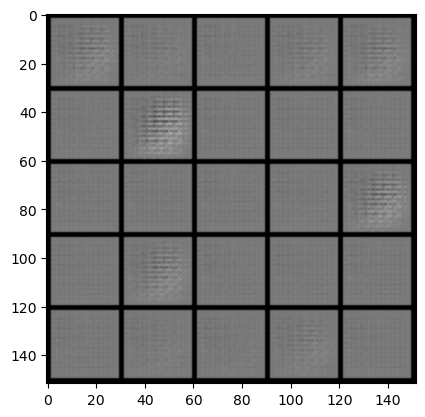

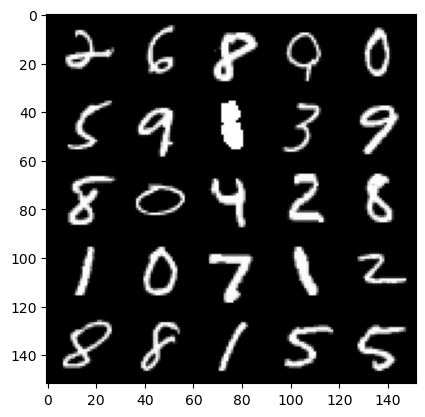

 13%|█▎        | 62/469 [00:04<00:30, 13.39it/s]

Step 1000: Generator loss: 2.0253947529792797, discriminator loss: 0.2211514019221065


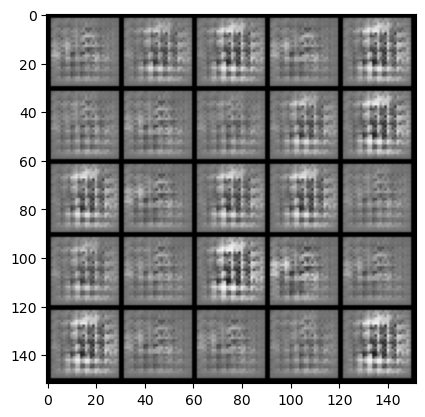

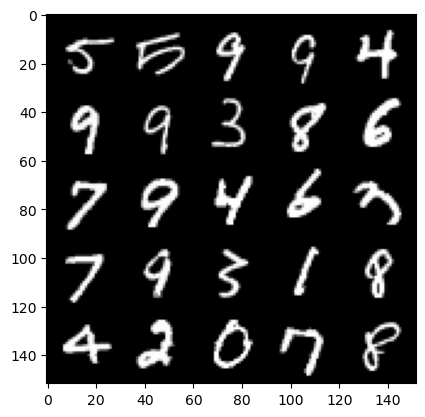

 20%|█▉        | 92/469 [00:06<00:25, 14.54it/s]

Step 1500: Generator loss: 1.8035080728679889, discriminator loss: 0.35815055574476756


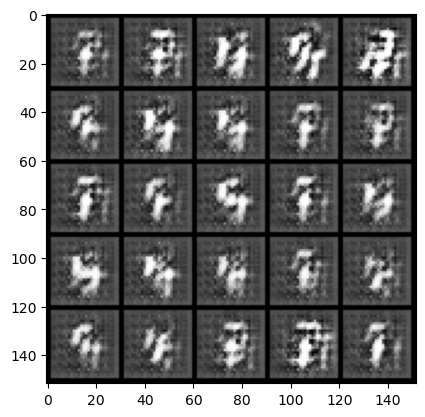

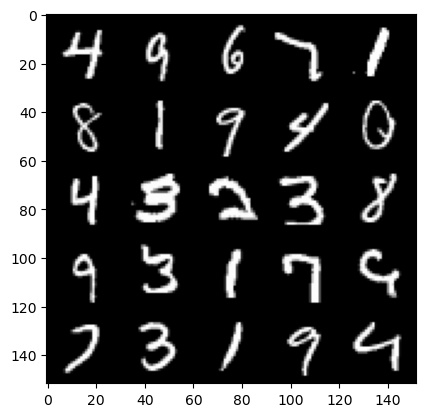

 26%|██▋       | 124/469 [00:08<00:23, 14.99it/s]

Step 2000: Generator loss: 1.2574015960097313, discriminator loss: 0.48761380815505984


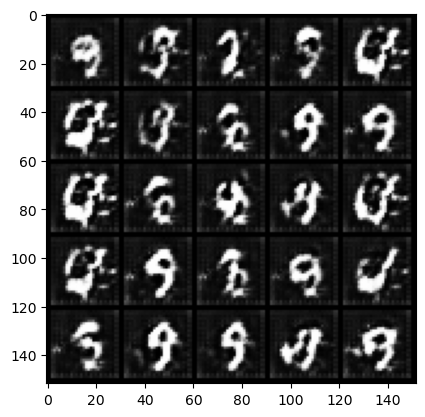

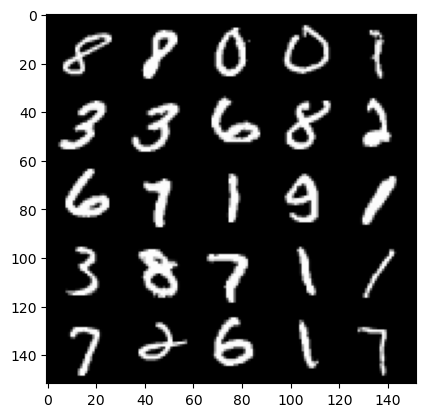

 33%|███▎      | 154/469 [00:10<00:20, 15.06it/s]

Step 2500: Generator loss: 0.9718115982413283, discriminator loss: 0.5649544830918314


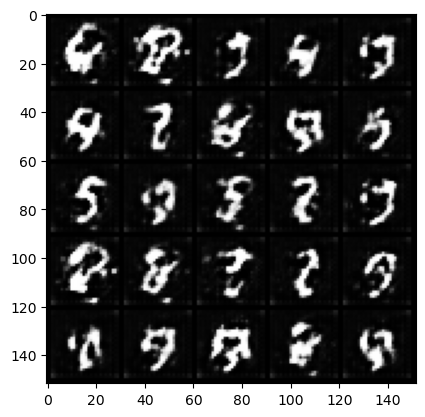

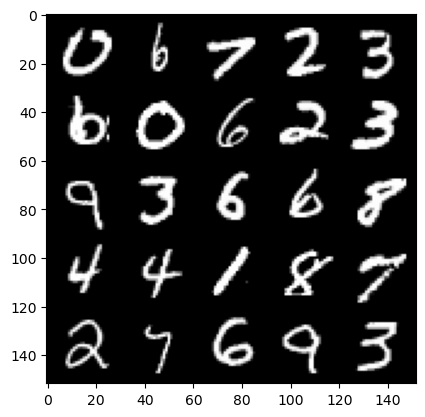

 40%|███▉      | 186/469 [00:12<00:18, 15.04it/s]

Step 3000: Generator loss: 0.8960739675760272, discriminator loss: 0.6037513972520829


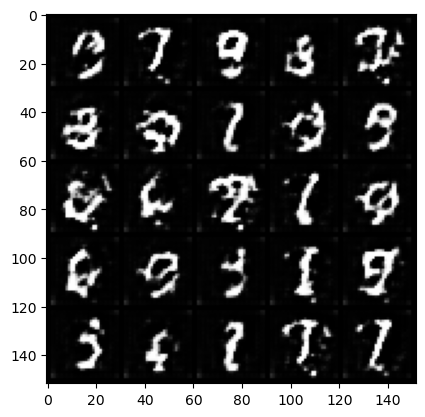

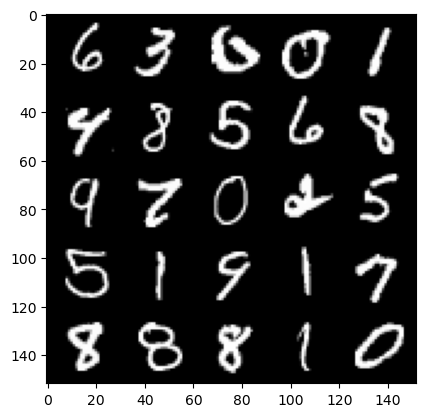

 46%|████▌     | 216/469 [00:14<00:16, 15.00it/s]

Step 3500: Generator loss: 0.8499317214488986, discriminator loss: 0.6167413690090179


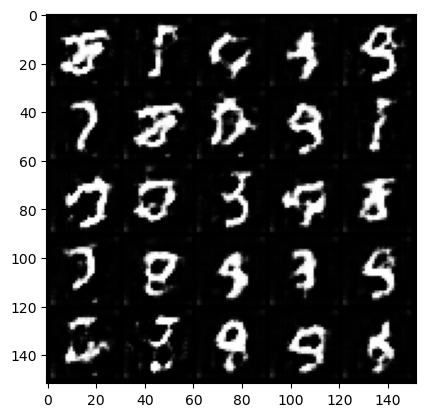

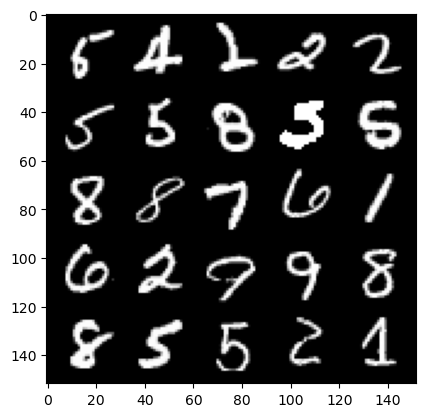

 53%|█████▎    | 248/469 [00:17<00:14, 14.74it/s]

Step 4000: Generator loss: 0.813695311903953, discriminator loss: 0.6335118271112434


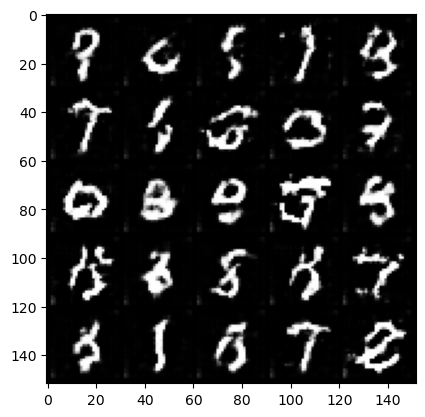

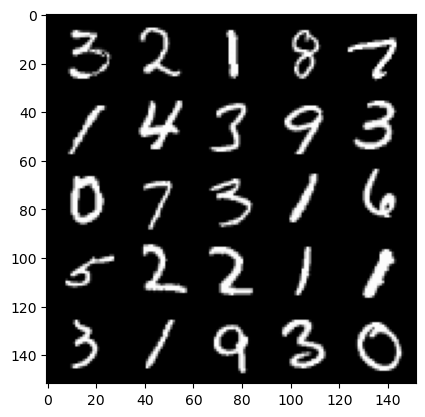

 59%|█████▉    | 278/469 [00:19<00:13, 14.46it/s]

Step 4500: Generator loss: 0.8080674701929095, discriminator loss: 0.6435809096097947


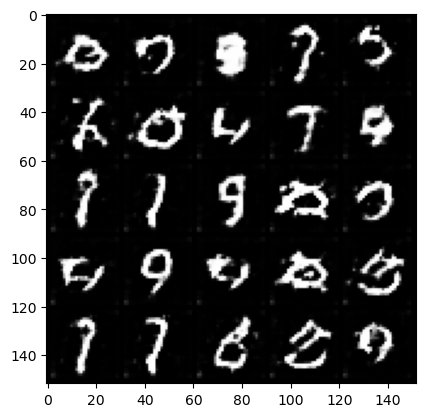

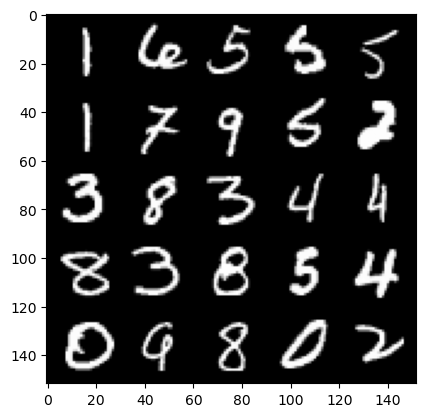

 66%|██████▌   | 310/469 [00:21<00:10, 14.68it/s]

Step 5000: Generator loss: 0.797088401854038, discriminator loss: 0.651026035070419


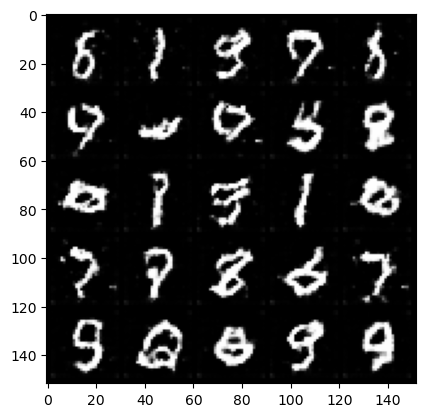

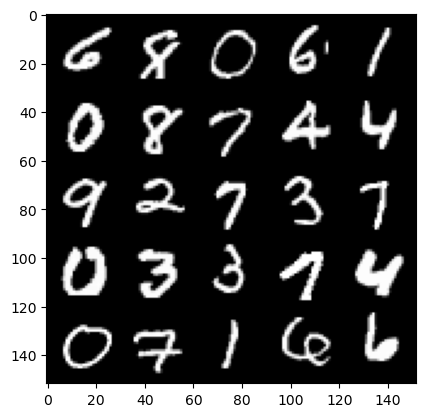

 72%|███████▏  | 340/469 [00:23<00:08, 14.69it/s]

Step 5500: Generator loss: 0.7828644742965694, discriminator loss: 0.6523007373809814


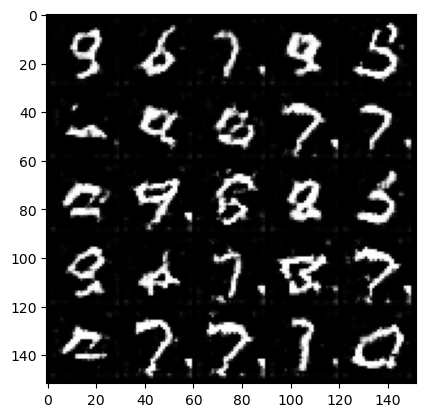

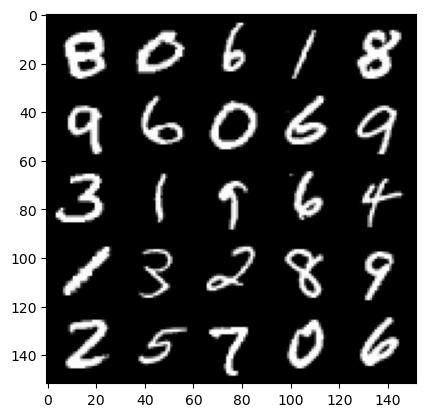

 79%|███████▉  | 372/469 [00:25<00:06, 14.72it/s]

Step 6000: Generator loss: 0.7735717378854741, discriminator loss: 0.6634145070314408


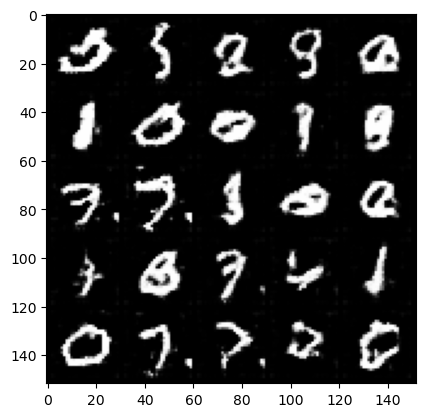

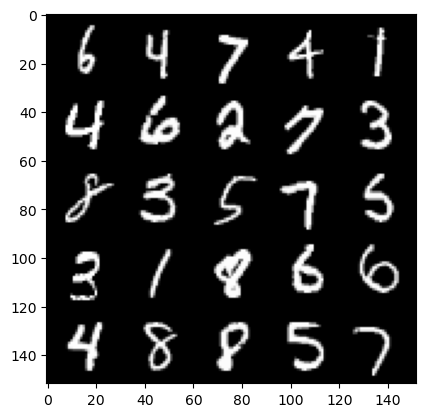

 86%|████████▌ | 402/469 [00:27<00:05, 13.31it/s]

Step 6500: Generator loss: 0.764951793432236, discriminator loss: 0.6674008982181551


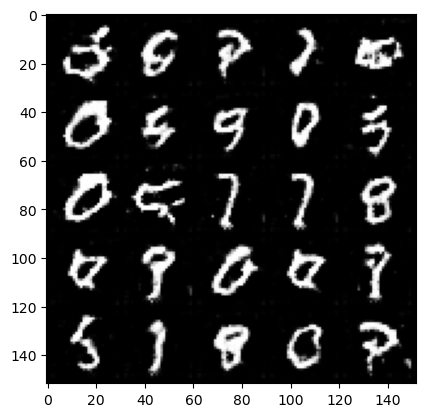

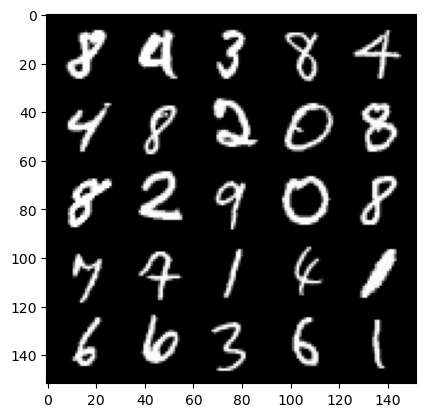

 93%|█████████▎| 434/469 [00:29<00:02, 14.80it/s]

Step 7000: Generator loss: 0.7585577164292334, discriminator loss: 0.6709779045581815


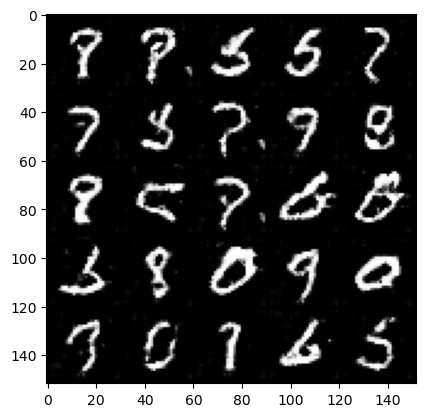

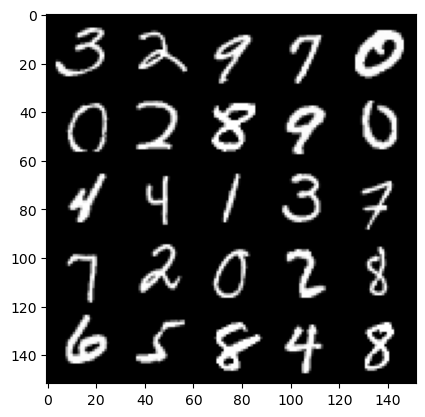

 99%|█████████▉| 464/469 [00:31<00:00, 15.24it/s]

Step 7500: Generator loss: 0.7579015690684325, discriminator loss: 0.675248231291771


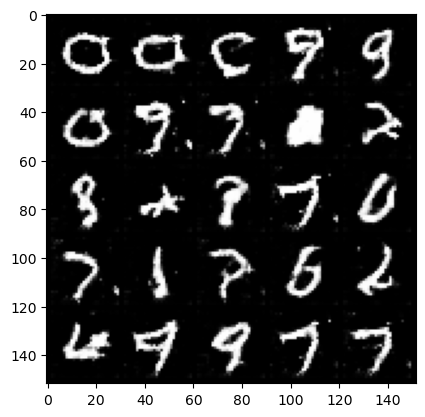

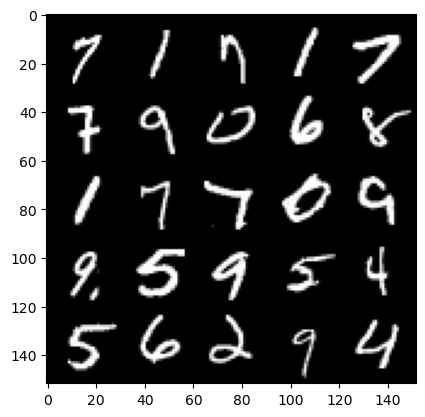

  6%|▌         | 26/469 [00:01<00:30, 14.52it/s]

Step 8000: Generator loss: 0.7503590584993358, discriminator loss: 0.6798930637836454


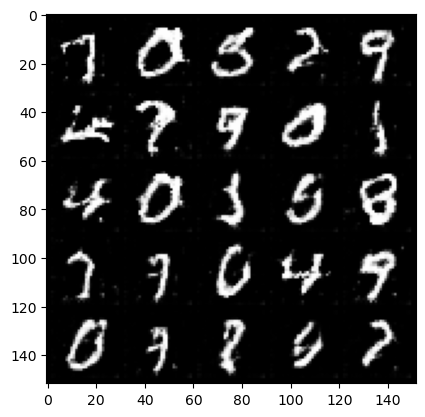

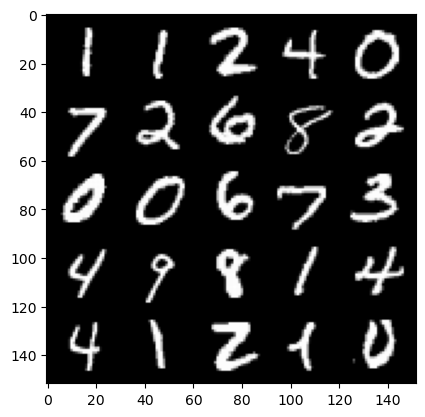

 12%|█▏        | 58/469 [00:04<00:29, 14.14it/s]

Step 8500: Generator loss: 0.7404119196534159, discriminator loss: 0.6856473464965823


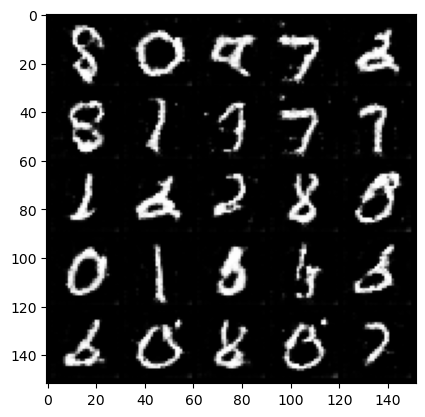

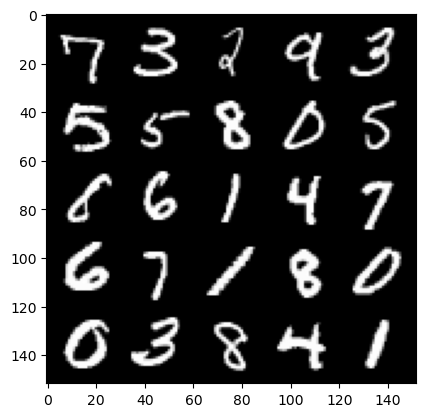

 19%|█▉        | 88/469 [00:06<00:26, 14.30it/s]

Step 9000: Generator loss: 0.7323165277242658, discriminator loss: 0.6896698001623152


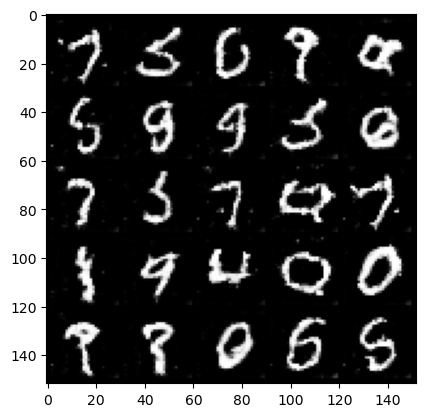

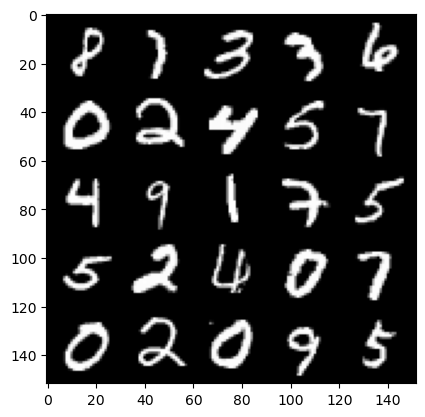

 26%|██▌       | 120/469 [00:08<00:24, 14.51it/s]

Step 9500: Generator loss: 0.7235015316605564, discriminator loss: 0.6933613638877864


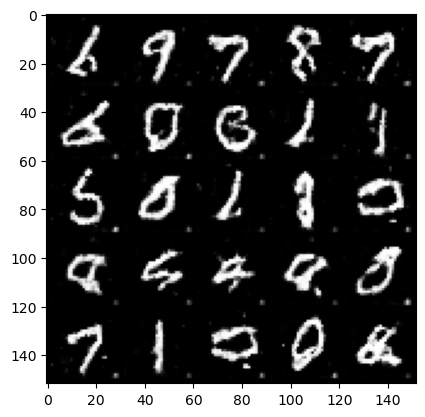

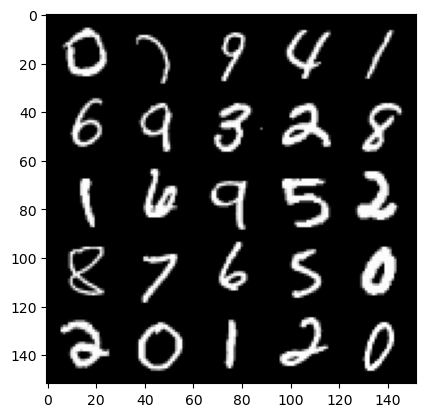

 32%|███▏      | 150/469 [00:10<00:21, 14.52it/s]

Step 10000: Generator loss: 0.7215651172399518, discriminator loss: 0.6965597107410436


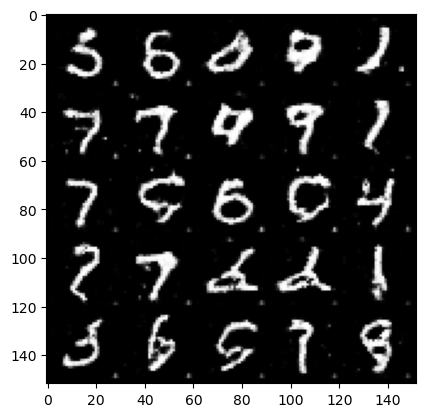

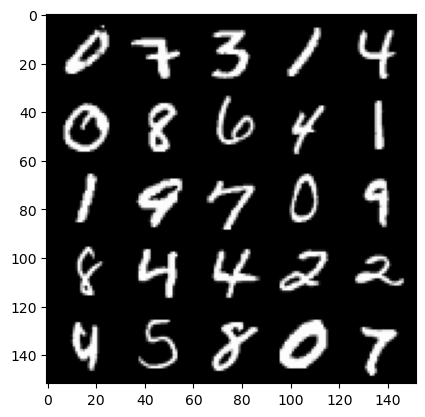

 39%|███▉      | 182/469 [00:12<00:19, 14.67it/s]

Step 10500: Generator loss: 0.7173616326451303, discriminator loss: 0.6969945189952848


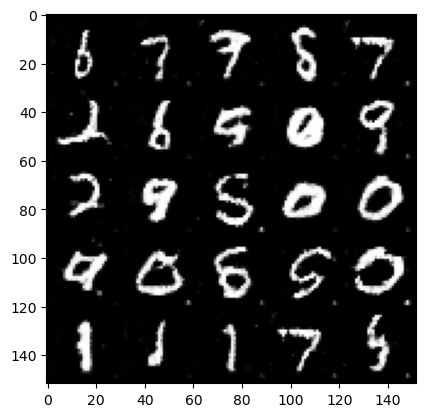

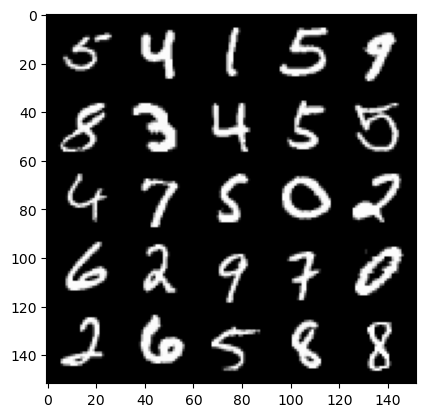

 45%|████▌     | 212/469 [00:14<00:17, 14.65it/s]

Step 11000: Generator loss: 0.7147603013515463, discriminator loss: 0.6970188587903973


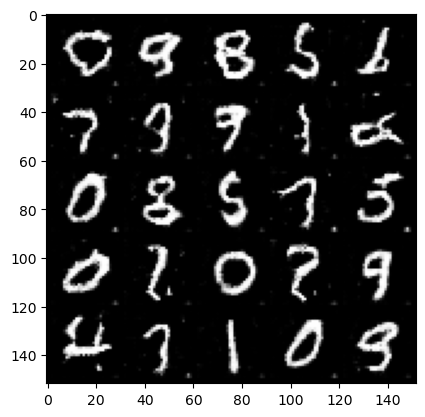

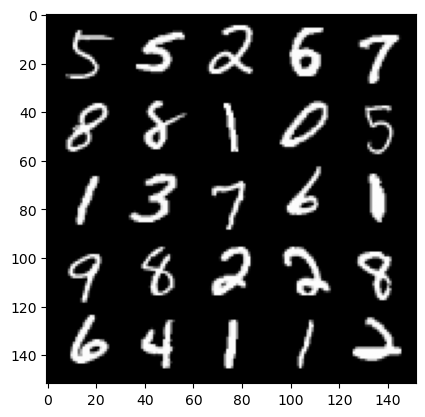

 52%|█████▏    | 244/469 [00:16<00:15, 14.78it/s]

Step 11500: Generator loss: 0.7086439875960343, discriminator loss: 0.6987173371315


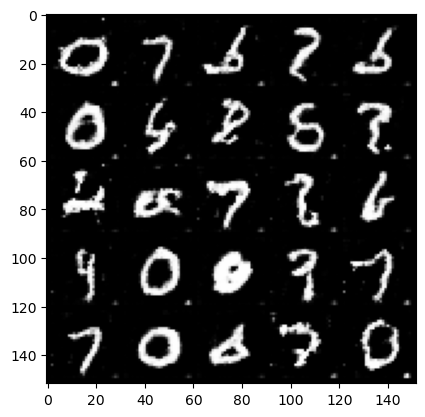

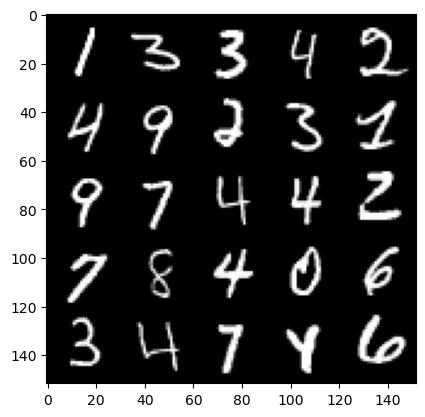

 58%|█████▊    | 274/469 [00:18<00:12, 15.25it/s]

Step 12000: Generator loss: 0.7064792109727855, discriminator loss: 0.6990258145332339


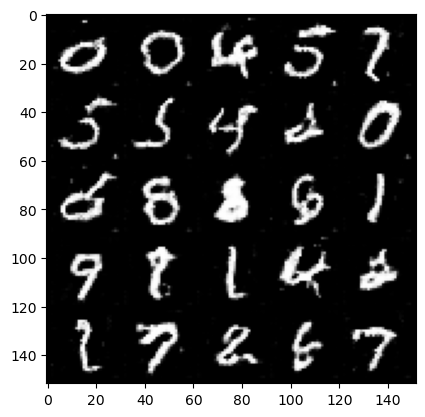

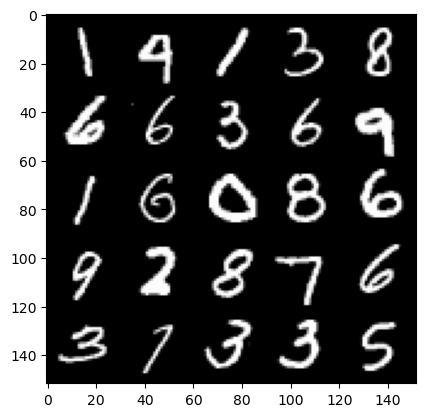

 65%|██████▌   | 306/469 [00:21<00:11, 14.02it/s]

Step 12500: Generator loss: 0.7083261671066284, discriminator loss: 0.6984179763793948


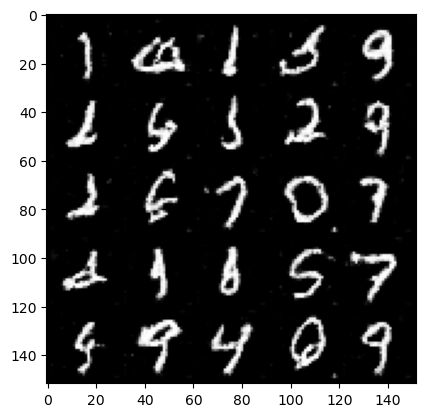

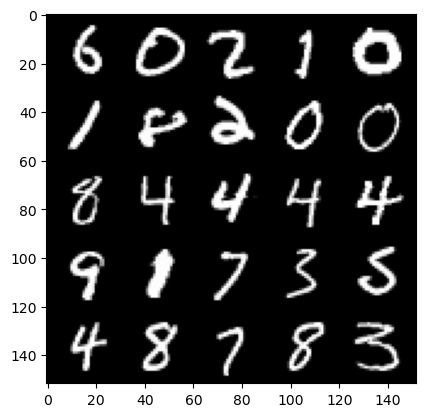

 72%|███████▏  | 336/469 [00:23<00:09, 13.48it/s]

Step 13000: Generator loss: 0.705237303137779, discriminator loss: 0.698009848833083


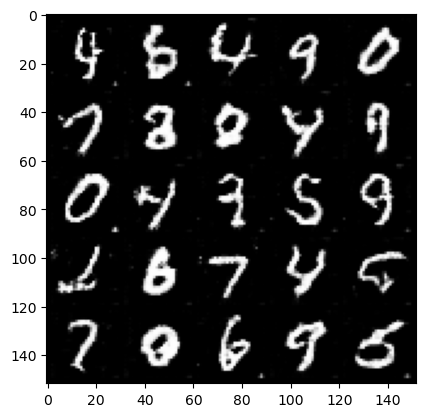

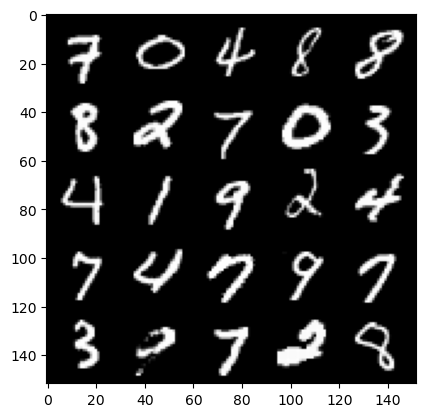

 78%|███████▊  | 368/469 [00:26<00:07, 14.17it/s]

Step 13500: Generator loss: 0.7041015199422835, discriminator loss: 0.699540974617005


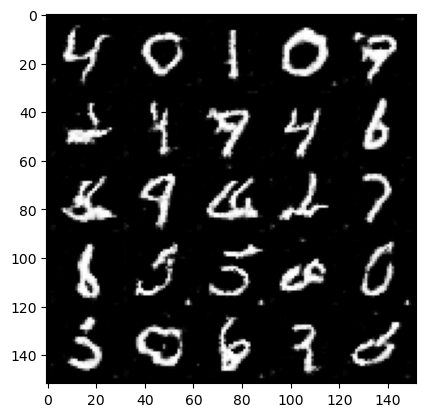

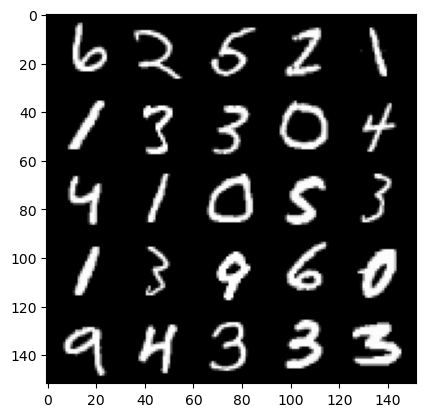

 85%|████████▍ | 398/469 [00:27<00:04, 14.37it/s]

Step 14000: Generator loss: 0.7038716518878928, discriminator loss: 0.6989819252490996


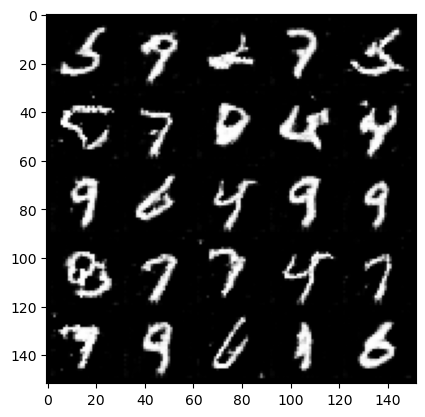

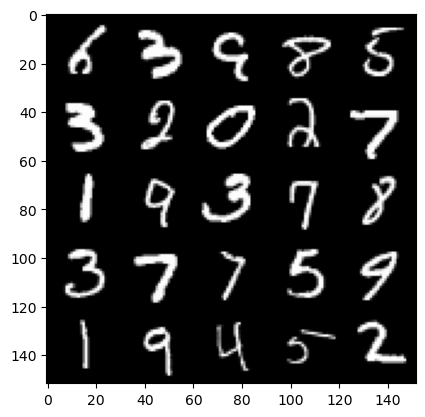

 92%|█████████▏| 430/469 [00:30<00:02, 14.78it/s]

Step 14500: Generator loss: 0.7014022226333619, discriminator loss: 0.6998850446939466


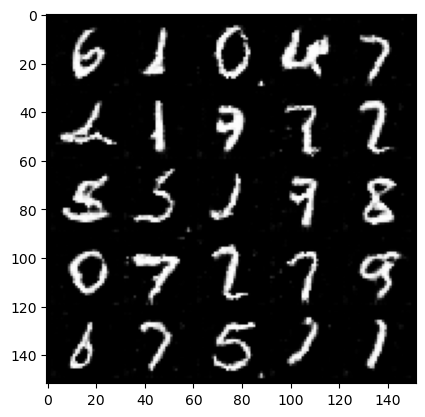

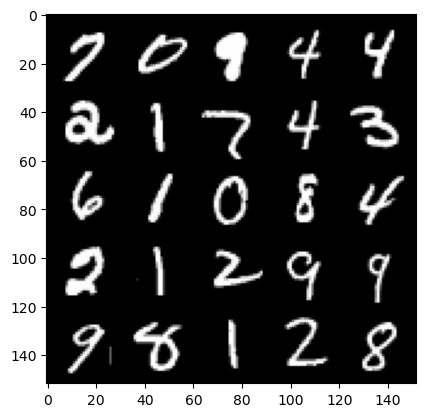

 98%|█████████▊| 460/469 [00:31<00:00, 14.48it/s]

Step 15000: Generator loss: 0.7005902156829835, discriminator loss: 0.6994228022098535


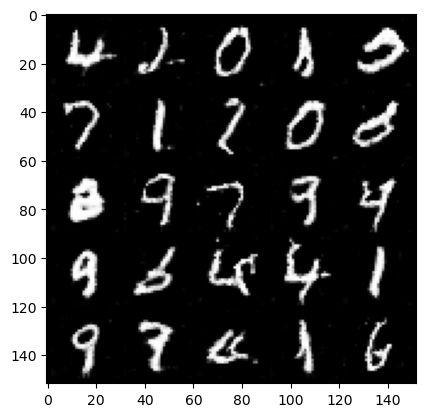

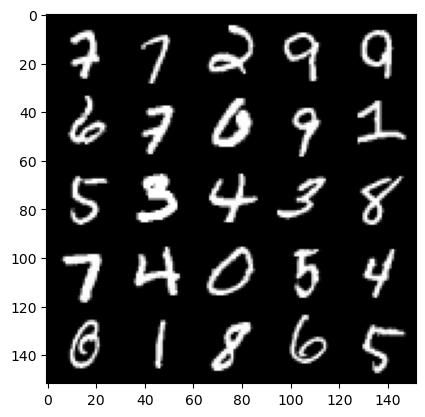

  5%|▍         | 22/469 [00:01<00:29, 15.03it/s]

Step 15500: Generator loss: 0.7014513265490522, discriminator loss: 0.6989007565975187


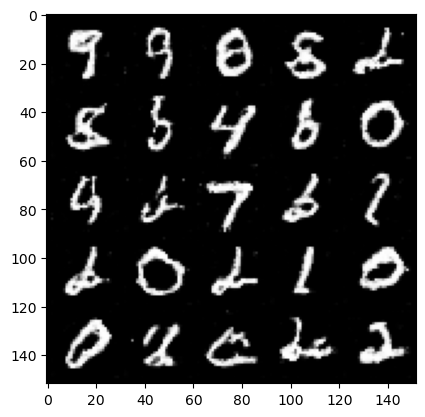

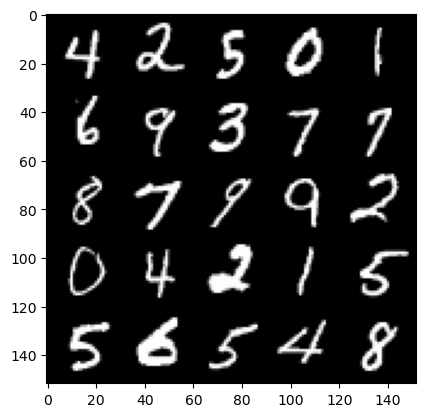

 12%|█▏        | 54/469 [00:03<00:28, 14.61it/s]

Step 16000: Generator loss: 0.6999160491228107, discriminator loss: 0.6994556742906567


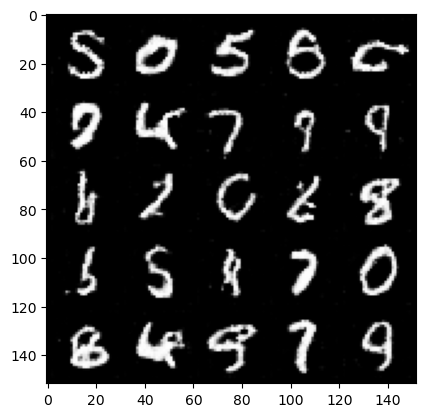

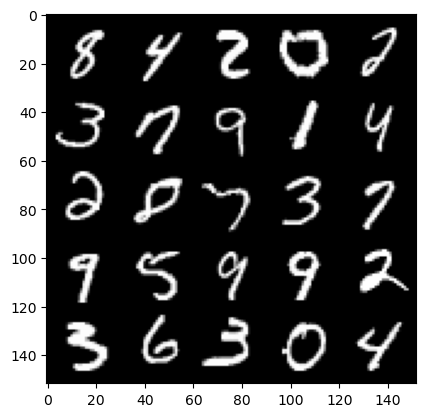

 18%|█▊        | 84/469 [00:05<00:26, 14.61it/s]

Step 16500: Generator loss: 0.6993596867322923, discriminator loss: 0.6986439737081533


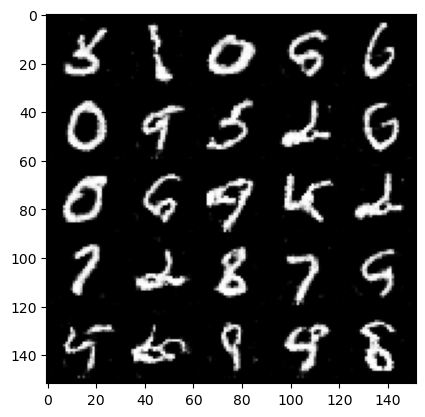

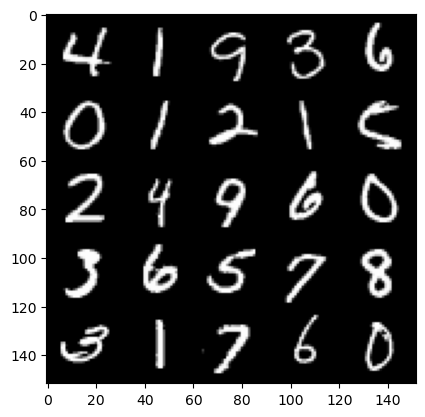

 25%|██▍       | 116/469 [00:07<00:23, 14.84it/s]

Step 17000: Generator loss: 0.6993427904844274, discriminator loss: 0.6987495955228809


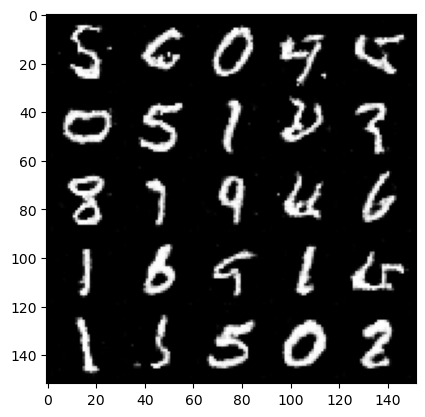

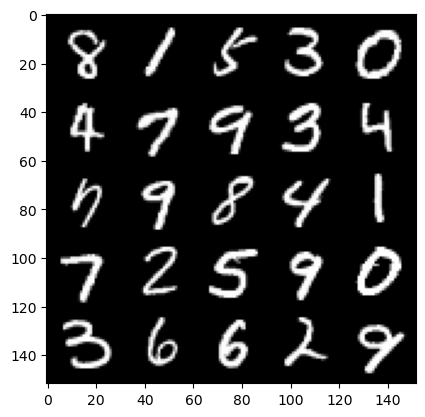

 31%|███       | 146/469 [00:09<00:20, 15.61it/s]

Step 17500: Generator loss: 0.69670605313778, discriminator loss: 0.6990170451402664


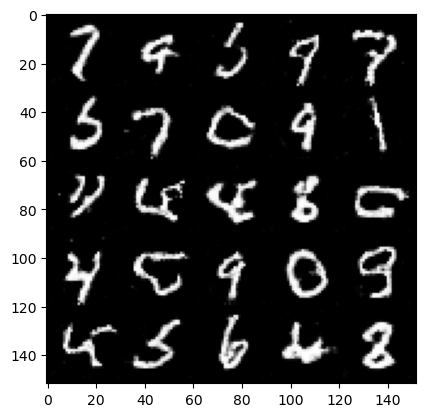

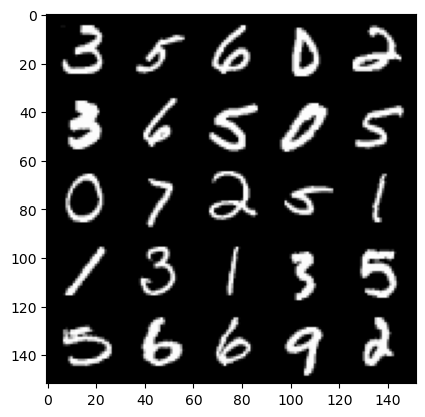

 38%|███▊      | 178/469 [00:11<00:19, 15.18it/s]

Step 18000: Generator loss: 0.6970301800966265, discriminator loss: 0.6984068456888192


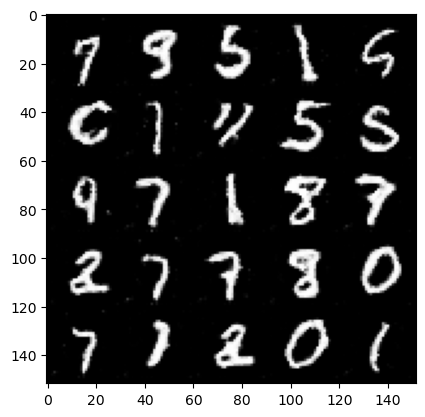

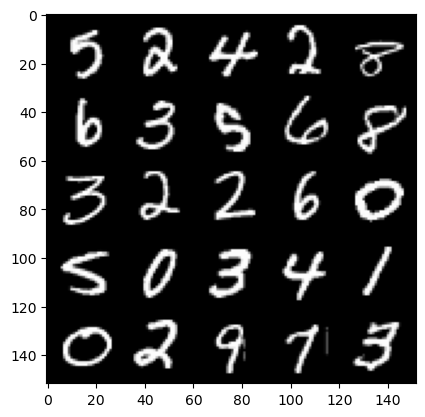

 44%|████▍     | 208/469 [00:13<00:17, 14.66it/s]

Step 18500: Generator loss: 0.6975457345247265, discriminator loss: 0.6984916890859598


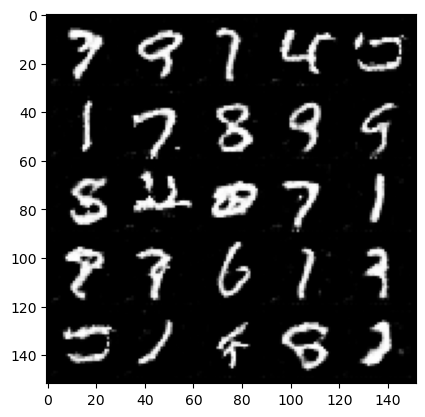

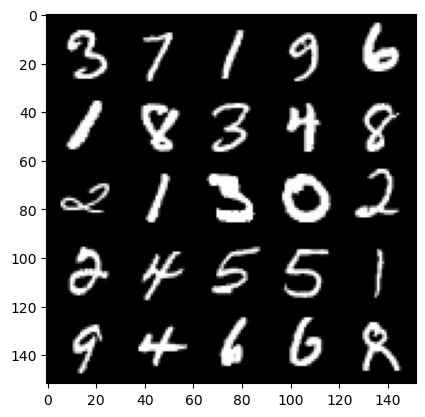

 51%|█████     | 240/469 [00:15<00:15, 15.13it/s]

Step 19000: Generator loss: 0.6975576575994485, discriminator loss: 0.6981022827625281


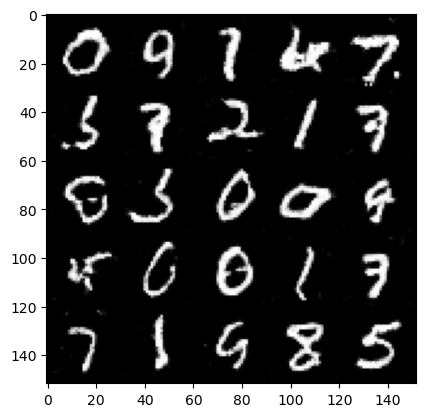

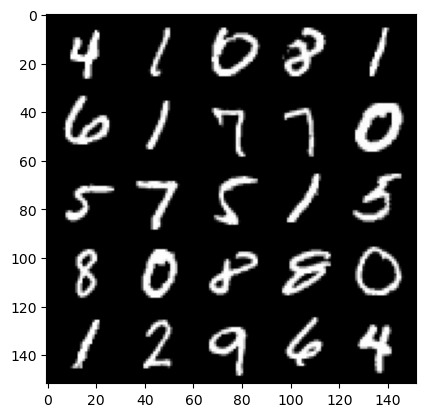

 58%|█████▊    | 270/469 [00:17<00:13, 15.14it/s]

Step 19500: Generator loss: 0.6974093888401984, discriminator loss: 0.6981163022518162


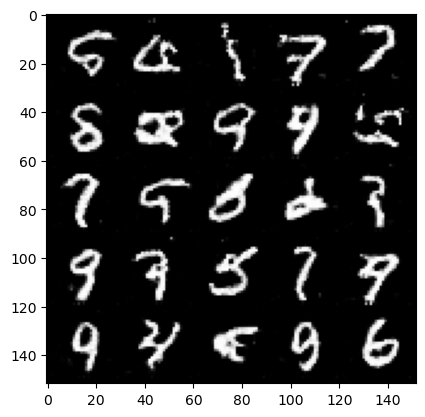

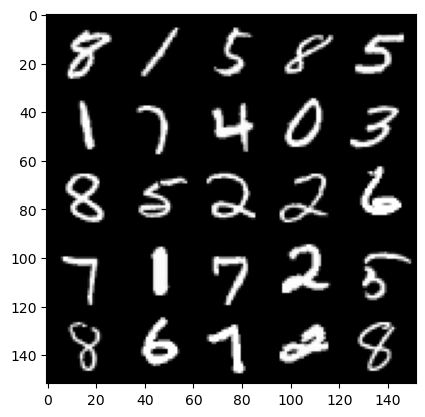

 64%|██████▍   | 302/469 [00:20<00:11, 15.01it/s]

Step 20000: Generator loss: 0.699754244446754, discriminator loss: 0.6978377822637558


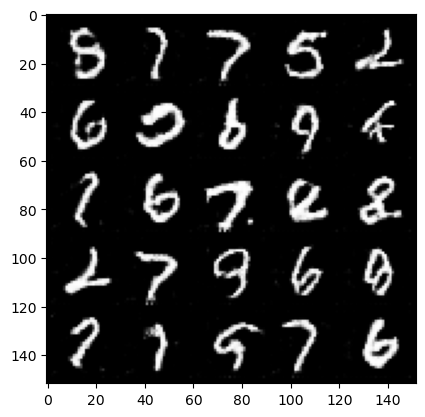

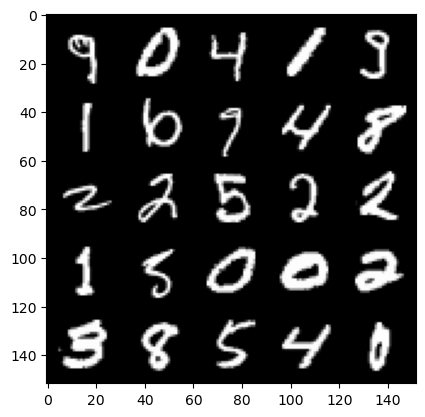

 71%|███████   | 332/469 [00:22<00:09, 14.48it/s]

Step 20500: Generator loss: 0.6965856113433841, discriminator loss: 0.6971217235326767


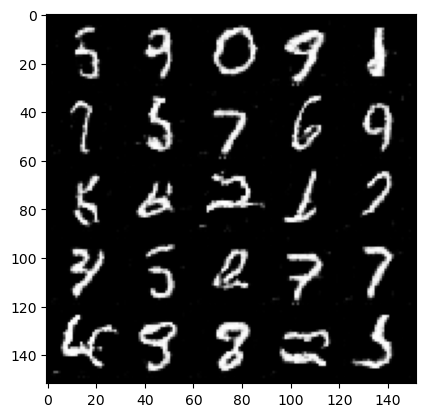

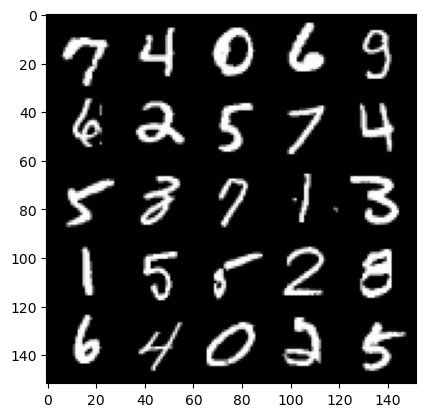

 78%|███████▊  | 364/469 [00:24<00:07, 14.79it/s]

Step 21000: Generator loss: 0.6982392055988316, discriminator loss: 0.6974066605567936


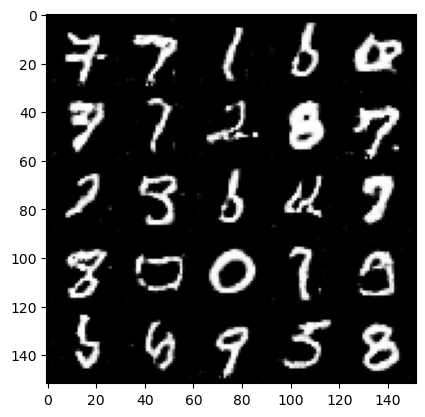

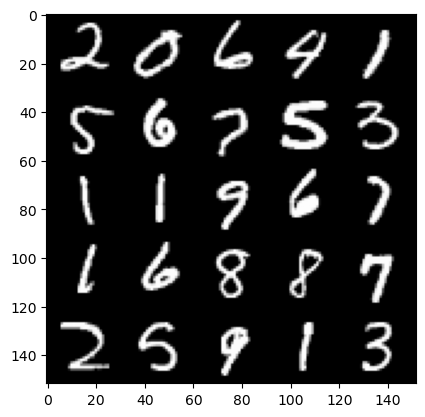

 84%|████████▍ | 394/469 [00:26<00:05, 14.93it/s]

Step 21500: Generator loss: 0.6971408337354663, discriminator loss: 0.6969576348066325


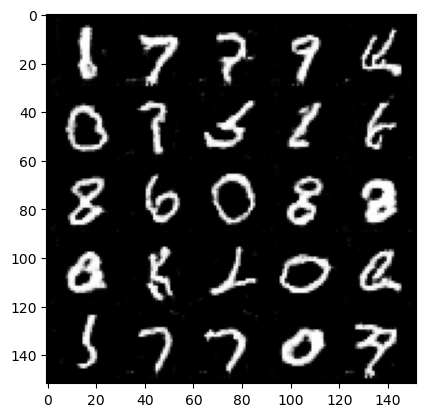

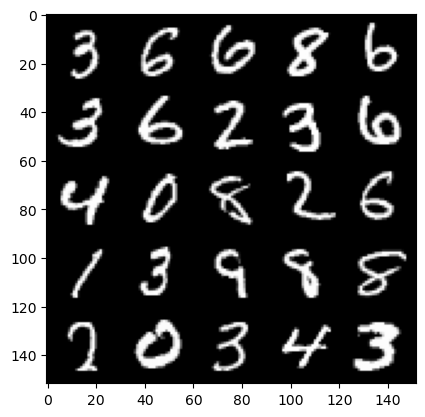

 91%|█████████ | 426/469 [00:29<00:02, 18.54it/s]

Step 22000: Generator loss: 0.6963349553346633, discriminator loss: 0.6965759601593022


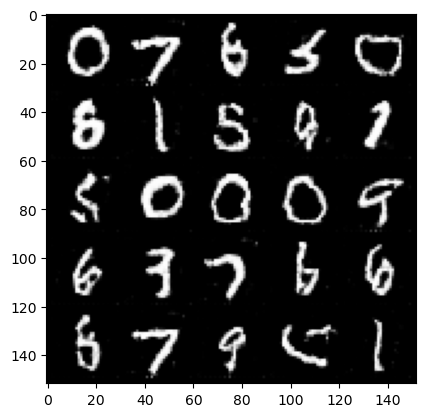

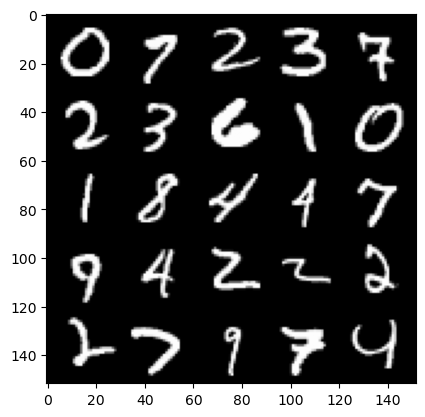

 97%|█████████▋| 456/469 [00:33<00:00, 14.07it/s]

Step 22500: Generator loss: 0.6969861810207365, discriminator loss: 0.6964451053142554


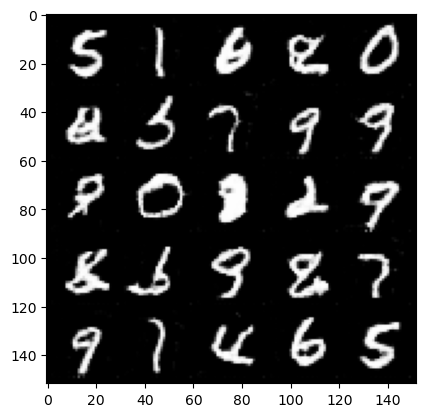

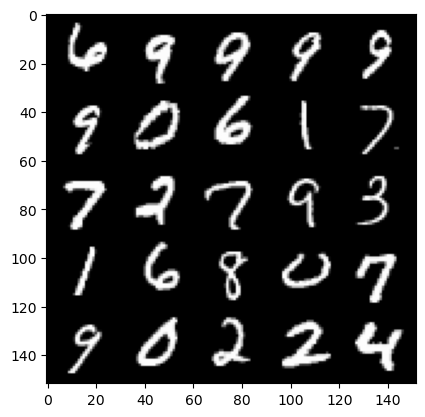

  4%|▍         | 18/469 [00:01<00:34, 12.91it/s]

Step 23000: Generator loss: 0.6962993900775902, discriminator loss: 0.6962153548002242


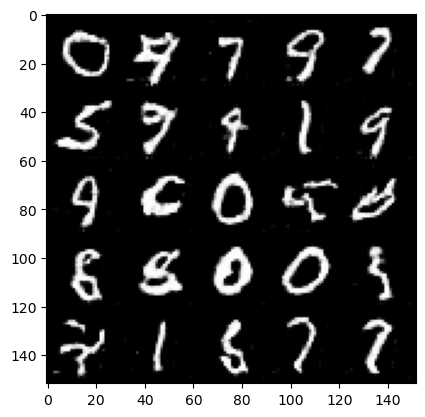

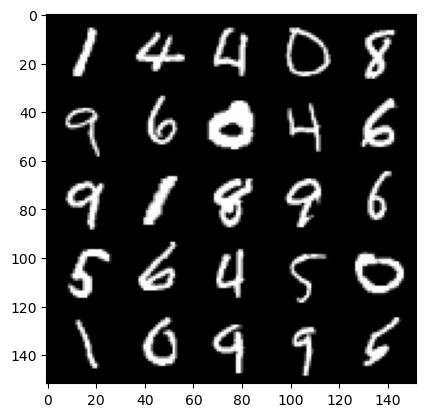

100%|██████████| 469/469 [00:34<00:00, 13.70it/s]


In [14]:
# Long training time! 23000 steps -> 30' in T4 GPU
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


##Salvar los modelos

Si los resultados son buenos y hemos evitado el modo colapso, pordemos grabar los modelos

In [15]:
torch.save(gen.state_dict(), 'DC_GAN_CIFAR_Gnet.pt')
torch.save(disc.state_dict(), 'DC_GAN_CIFAR_Dnet.pt')

## Cargar los modelos

Para cargar los modelos hemos de crear **exactamente** el mismo objeto con la misma clase generadora y los mismos parámetros. También hemos de llevarlo al dispositivo donde tenemos los datos si queremos evaluarlo.

In [16]:
# Generador
gen2 = Generator(z_dim).to(device)
gen2.load_state_dict(torch.load('DC_GAN_CIFAR_Gnet.pt'))
gen2.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [17]:
# Discriminador (no es necesario si solo queremos ver nuevas muestras)
disc2 = Discriminator().to(device)
disc2.load_state_dict(torch.load('DC_GAN_CIFAR_Dnet.pt'))
disc2.eval()

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)

## DC GANS con TensorFlow

Puedes explorar ejemplos del mismo tipo de GAN con tensorFlow aquí:

https://www.tensorflow.org/tutorials/generative/dcgan

## Referencias

+ Notebook basado en ejercicios de [DeepLearning.AI](https://www.deeplearning.ai/)
+ Documentación de [PyTorch](https://pytorch.org/docs/stable/index.html)

# EOF